# Simulate data
This notebook generates simulated experiments by sampling from the VAE using the user selected template experiment as a guide for sampling

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random
import seaborn as sns
import umap
from keras.models import load_model
from sklearn.decomposition import PCA
import pickle

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

sys.path.append("../")
from functions import utils, generate_labeled_data

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

In [4]:
# Load real compendium
compendium_file = os.path.join(
    local_dir,
    "recount2_compedium_data.tsv")

normalized_compendium_file = os.path.join(
    local_dir,
    "normalized_recount2_compendium_data.tsv")

# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load pickled files
scaler_transform_file = os.path.join(
    local_dir,
    "scaler_transform.pickle")

scaler = pickle.load(open(scaler_transform_file, "rb" ) )

In [5]:
# Read data
compendium = pd.read_csv(
    compendium_file,
    header=0,
    sep='\t',
    index_col=0)

normalized_compendium = pd.read_csv(
    normalized_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

### Simulate experiments using selected template experiment

In [6]:
"""
# Simulate experiments
# Make sure range is correct
# Generate multiple simulated datasets
for i in range(num_runs):
    generate_labeled_data.shift_template_experiment(
        normalized_compendium_file,
        project_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        i)"""

'\n# Simulate experiments\n# Make sure range is correct\n# Generate multiple simulated datasets\nfor i in range(num_runs):\n    generate_labeled_data.shift_template_experiment(\n        normalized_compendium_file,\n        project_id,\n        NN_architecture,\n        dataset_name,\n        scaler,\n        local_dir,\n        base_dir,\n        i)'

In [7]:
# Load shared genes
shared_genes_file = os.path.join(
    local_dir,
    "shared_gene_ids.pickle")

# Load pickled files
shared_genes = pickle.load(open(shared_genes_file, "rb" ))

In [8]:
"""
# Truncate simulated experiments
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]

for i in range(num_runs):
    simulated_data_file = os.path.join(
        local_dir, 
        "pseudo_experiment",
        "selected_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    # Read simulated data
    simulated_data = pd.read_csv(
        simulated_data_file,
        header=0,
        sep='\t',
        index_col=0)
    
    # Drop samples
    simulated_data = simulated_data.drop(smRNA_samples)
    # Drop genes
    simulated_data = simulated_data[shared_genes]
    
    # Save 
    simulated_data.to_csv(simulated_data_file, float_format='%.5f', sep='\t')"""

'\n# Truncate simulated experiments\nsmRNA_samples = ["SRR493961",\n                 "SRR493962",\n                 "SRR493963",\n                 "SRR493964",\n                 "SRR493965",\n                 "SRR493966",\n                 "SRR493967",\n                 "SRR493968",\n                 "SRR493969",\n                 "SRR493970",\n                 "SRR493971",\n                 "SRR493972"]\n\nfor i in range(num_runs):\n    simulated_data_file = os.path.join(\n        local_dir, \n        "pseudo_experiment",\n        "selected_simulated_data_"+project_id+"_"+str(i)+".txt")\n    \n    # Read simulated data\n    simulated_data = pd.read_csv(\n        simulated_data_file,\n        header=0,\n        sep=\'\t\',\n        index_col=0)\n    \n    # Drop samples\n    simulated_data = simulated_data.drop(smRNA_samples)\n    # Drop genes\n    simulated_data = simulated_data[shared_genes]\n    \n    # Save \n    simulated_data.to_csv(simulated_data_file, float_format=\'%.5f\', sep

### Quick validation of simulated experiments

**Spot check expression values**
1. Values are different between different simulated data files (meaning it was a different simulated dataset), and different from the template experiment
2. Range of values is scaled the same as the compendium

In [9]:
# Compendium
print(compendium.shape)
compendium.head()

(1552, 17810)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000281909.1,ENSG00000281912.1,ENSG00000282458.1,ENSG00000282608.1,ENSG00000283122.1,ENSG00000283307.1,ENSG00000283440.1,ENSG00000283486.1,ENSG00000283597.1,ENSG00000283632.1
SRR1604987,35.467,0.027,32.157,2.359,2.588,0.000,5.738,43.607,6.178,11.840,...,0.035,0.920,0.803,0.001,0.044,0.023,0.141,0.865,0.0,0.069
SRR1604988,36.739,0.014,31.769,2.442,2.880,0.029,5.802,44.477,5.770,11.409,...,0.039,0.800,0.692,0.001,0.048,0.000,0.099,1.158,0.0,0.098
SRR1604989,23.421,0.000,26.339,2.416,2.935,0.000,4.174,33.964,8.310,11.858,...,0.079,0.571,1.096,0.000,0.000,0.000,0.065,3.023,0.0,0.048
SRR1604990,22.413,0.000,26.681,2.747,3.282,0.009,4.233,33.616,8.207,12.296,...,0.108,0.485,1.191,0.000,0.008,0.000,0.026,2.816,0.0,0.036
SRR1604991,22.274,0.000,28.511,1.818,2.095,0.011,3.693,32.073,4.572,11.778,...,0.001,0.406,0.635,0.000,0.001,0.000,0.400,2.006,0.0,0.007


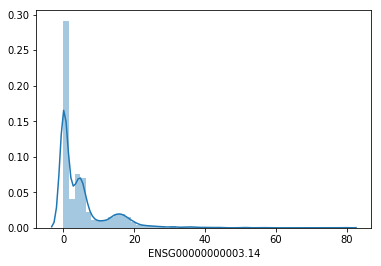

In [10]:
sns.distplot(compendium['ENSG00000000003.14'])

In [11]:
# Template experiment
print(template_data.shape)
template_data.head()

(24, 17810)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000281909.1,ENSG00000281912.1,ENSG00000282458.1,ENSG00000282608.1,ENSG00000283122.1,ENSG00000283307.1,ENSG00000283440.1,ENSG00000283486.1,ENSG00000283597.1,ENSG00000283632.1
SRR493937,3.80015,0.01819,9.12846,1.58580,0.71395,84.99054,19.94300,12.06559,2.49882,7.71300,...,0.07070,0.36738,1.25380,1.38064,0.24872,0.00000,0.36410,1.54584,0.01736,3.24737
SRR493938,3.79847,0.00000,9.15767,1.45602,0.73897,85.78832,19.62125,11.73886,2.43531,7.12581,...,0.05820,0.26465,1.10662,1.19439,0.26725,0.03275,0.25133,1.59652,0.03081,3.11533
SRR493939,20.22213,0.00000,15.52207,3.94492,2.51226,8.07295,47.24608,18.86696,2.44323,12.14367,...,0.31796,1.20854,1.73049,1.27886,0.22139,0.00000,0.08052,0.43133,0.00423,1.07452
SRR493940,19.98833,0.00000,17.14030,3.97722,2.37885,7.59923,46.59446,18.92119,2.44828,12.04896,...,0.19003,1.11596,1.68578,1.42491,0.33488,0.00000,0.17868,0.51643,0.00845,1.13068
SRR493941,3.23923,0.01940,9.06932,2.18158,1.00815,17.67589,19.37114,11.75976,1.97073,6.74071,...,0.14164,0.43364,1.16901,1.16727,0.45015,0.05986,0.08620,0.53790,0.00000,5.30159


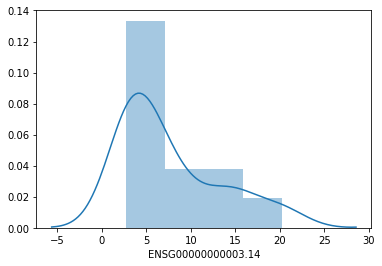

In [12]:
sns.distplot(template_data['ENSG00000000003.14'])

In [13]:
# Manual select one simulated experiment
simulated_file_1 = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_simulated_data_"+project_id+"_0.txt")

# Read data
simulated_test_1 = pd.read_csv(
    simulated_file_1,
    header=0,
    sep='\t',
    index_col=0)

print(simulated_test_1.shape)
simulated_test_1.head()

(24, 17810)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000281909.1,ENSG00000281912.1,ENSG00000282458.1,ENSG00000282608.1,ENSG00000283122.1,ENSG00000283307.1,ENSG00000283440.1,ENSG00000283486.1,ENSG00000283597.1,ENSG00000283632.1
SRR493937,5.865,0.255,11.694,1.997,2.082,32.547,12.209,17.364,2.717,6.107,...,0.323,0.781,2.507,0.961,0.442,0.061,0.410,1.861,0.114,2.258
SRR493938,5.864,0.255,11.677,1.995,2.080,32.526,12.192,17.363,2.707,6.098,...,0.322,0.781,2.504,0.959,0.442,0.061,0.409,1.861,0.114,2.259
SRR493939,9.652,0.122,18.086,3.369,2.882,9.261,11.726,18.000,4.297,8.169,...,0.499,0.886,2.910,1.358,0.292,0.053,0.222,2.926,0.081,1.303
SRR493940,9.655,0.123,18.176,3.380,2.891,9.268,11.705,18.016,4.317,8.167,...,0.502,0.888,2.908,1.359,0.293,0.054,0.223,2.928,0.081,1.300
SRR493941,4.462,0.276,10.963,1.750,1.818,21.983,10.077,16.996,2.561,5.611,...,0.268,0.647,2.398,0.727,0.629,0.059,0.353,1.283,0.109,2.492


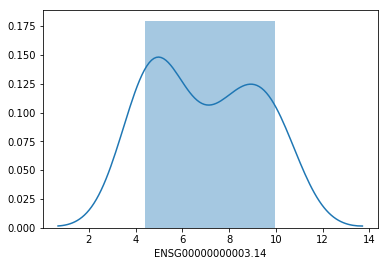

In [14]:
sns.distplot(simulated_test_1['ENSG00000000003.14'])

In [15]:
# Manual select another simulated experiment
simulated_file_2 = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_simulated_data_"+project_id+"_10.txt")

# Read data
simulated_test_2 = pd.read_csv(
    simulated_file_2,
    header=0,
    sep='\t',
    index_col=0)

print(simulated_test_2.shape)
simulated_test_2.head()

(24, 17810)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000281909.1,ENSG00000281912.1,ENSG00000282458.1,ENSG00000282608.1,ENSG00000283122.1,ENSG00000283307.1,ENSG00000283440.1,ENSG00000283486.1,ENSG00000283597.1,ENSG00000283632.1
SRR493937,9.695,0.363,29.835,3.866,4.282,12.191,7.044,21.898,6.088,7.714,...,1.088,0.766,1.320,0.972,0.700,0.248,0.576,1.826,0.435,1.342
SRR493938,9.694,0.362,29.806,3.858,4.279,12.201,7.030,21.897,6.070,7.703,...,1.086,0.765,1.316,0.970,0.700,0.247,0.575,1.823,0.434,1.341
SRR493939,8.558,0.091,41.561,5.377,4.860,1.407,3.208,21.236,8.574,8.281,...,1.168,0.795,1.632,0.397,0.204,0.075,0.156,2.168,0.222,0.494
SRR493940,8.530,0.092,41.574,5.391,4.866,1.409,3.198,21.228,8.584,8.265,...,1.173,0.793,1.625,0.395,0.204,0.076,0.157,2.167,0.225,0.494
SRR493941,9.523,0.580,25.327,3.524,4.051,11.472,7.743,18.427,5.555,7.124,...,0.997,0.741,1.403,0.829,1.058,0.267,0.564,1.593,0.473,1.489


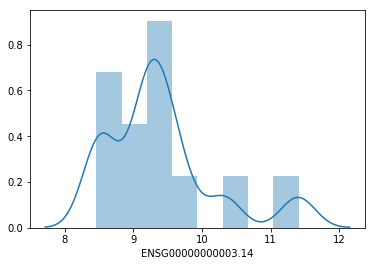

In [16]:
sns.distplot(simulated_test_2['ENSG00000000003.14'])

**Check clustering of simulated samples**

Check UMAP of original experiment and simulated experiments. Expect to see a similar structure in the template and simulated experiments. Also expect to see that the simulated experiment follows the distribution of the compendium.

**Visualization in latent space**

In [17]:
# Load VAE models
model_encoder_file = glob.glob(os.path.join(
        NN_dir,
        "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_model.h5"))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_weights.h5"))[0]

# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
pca = PCA(n_components=2)

In [19]:
# Embedding of real compendium (encoded)

# Scale compendium
compendium_scaled = scaler.transform(compendium)
compendium_scaled_df = pd.DataFrame(compendium_scaled,
                                    columns=compendium.columns,
                                    index=compendium.index)

# Encode compendium into latent space
compendium_encoded = loaded_model.predict_on_batch(compendium_scaled_df)

compendium_encoded_df = pd.DataFrame(data=compendium_encoded, 
                                     index=compendium.index)

# Get and save model
#model = umap.UMAP(random_state=randomState).fit(compendium_encoded_df)
model = pca.fit(compendium_encoded_df)

compendium_UMAPencoded = model.transform(compendium_encoded_df)

compendium_UMAPencoded_df = pd.DataFrame(data=compendium_UMAPencoded,
                                         index=compendium_encoded_df.index,
                                         columns=['1','2'])

# Add label
compendium_UMAPencoded_df['experiment_id'] = 'background'

In [20]:
# Embedding of real template experiment (encoded)

# Scale template data
template_data_scaled = scaler.transform(template_data)
template_data_scaled_df = pd.DataFrame(template_data_scaled,
                                    columns=template_data.columns,
                                    index=template_data.index)

# Encode template experiment into latent space
template_encoded = loaded_model.predict_on_batch(template_data_scaled)
template_encoded_df = pd.DataFrame(data=template_encoded,
                                   index=template_data.index)

template_UMAPencoded = model.transform(template_encoded_df)

template_UMAPencoded_df = pd.DataFrame(data=template_UMAPencoded,
                                         index=template_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
template_UMAPencoded_df['experiment_id'] = 'template_experiment'

In [21]:
# Embedding of simulated experiment (encoded)

# Scale simulated data
simulated_test_2_scaled = scaler.transform(simulated_test_2)
simulated_test_2_scaled_df = pd.DataFrame(simulated_test_2_scaled,
                                          columns=simulated_test_2.columns,
                                          index=simulated_test_2.index)

# Encode simulated experiment into latent space
simulated_encoded = loaded_model.predict_on_batch(simulated_test_2_scaled)
simulated_encoded_df = pd.DataFrame(
    simulated_encoded, index=simulated_test_2.index)

simulated_UMAPencoded = model.transform(simulated_encoded_df)

simulated_UMAPencoded_df = pd.DataFrame(data=simulated_UMAPencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_UMAPencoded_df['experiment_id'] = 'simulated_experiment'

In [22]:
# Concatenate dataframes
combined_UMAPencoded_df = pd.concat([compendium_UMAPencoded_df, 
                                    template_UMAPencoded_df,
                                    simulated_UMAPencoded_df])

combined_UMAPencoded_df.shape

(1600, 3)

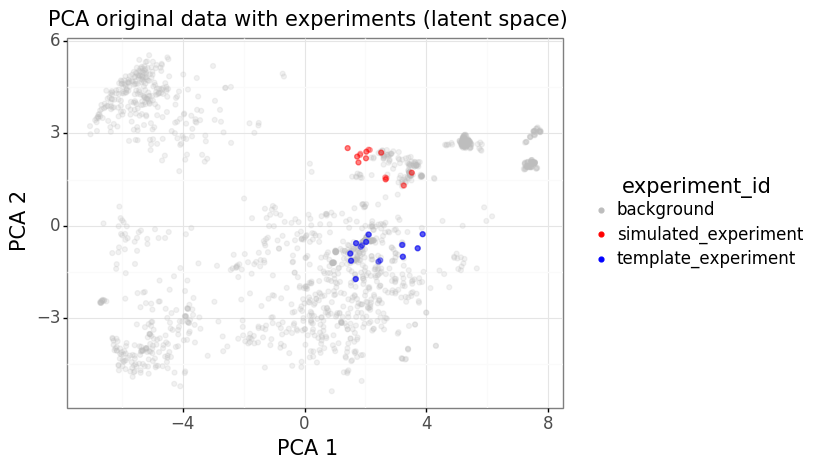

<ggplot: (8730922004509)>


In [23]:
# Plot
fig = ggplot(combined_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA original data with experiments (latent space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.1, 
                  color='red')

print(fig)

**Visualization in gene space**

In [24]:
# Embedding of real compendium

# Get and save model
model = umap.UMAP(random_state=randomState).fit(compendium_scaled_df)

compendium_UMAPencoded = model.transform(compendium_scaled_df)

compendium_UMAPencoded_df = pd.DataFrame(data=compendium_UMAPencoded,
                                         index=compendium_scaled_df.index,
                                         columns=['1','2'])
# Add label
compendium_UMAPencoded_df['experiment_id'] = 'background'

In [25]:
# Embedding of real template experiment

template_UMAPencoded = model.transform(template_data_scaled_df)

template_UMAPencoded_df = pd.DataFrame(data=template_UMAPencoded,
                                         index=template_data_scaled_df.index,
                                         columns=['1','2'])

# Add back label column
template_UMAPencoded_df['experiment_id'] = 'template_experiment'

In [26]:
# Embedding of simulated template experiment

simulated_UMAPencoded = model.transform(simulated_test_2_scaled_df)

simulated_UMAPencoded_df = pd.DataFrame(data=simulated_UMAPencoded,
                                         index=simulated_test_2_scaled_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_UMAPencoded_df['experiment_id'] = 'simulated_experiment'

In [27]:
# Concatenate dataframes
combined_UMAPencoded_df = pd.concat([compendium_UMAPencoded_df, 
                                    template_UMAPencoded_df,
                                    simulated_UMAPencoded_df])

combined_UMAPencoded_df.shape

(1600, 3)

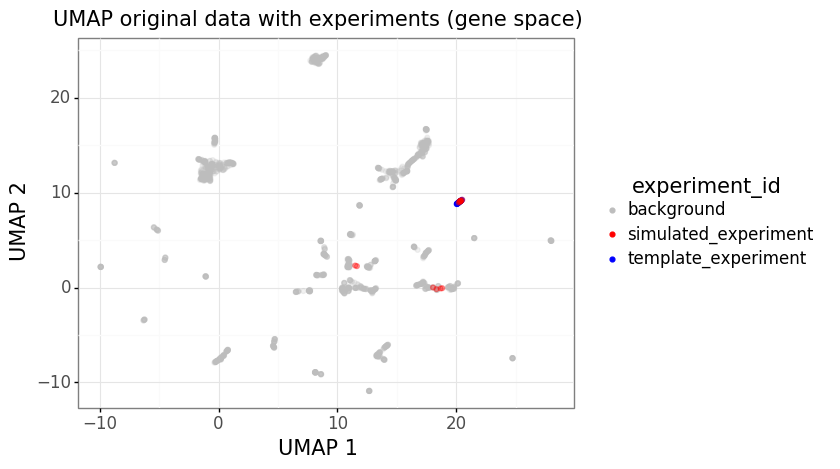

<ggplot: (8730923424109)>


In [28]:
# Plot
fig = ggplot(combined_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'UMAP original data with experiments (gene space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.2, 
                  color='red')

print(fig)